In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
def get_data_and_first_cleaning():
    rooth_path = '../rawdata/training/'
    failures_df = pd.read_csv(rooth_path + 'wind-farm-1-failures-training.csv')
    locations_df = gpd.read_file(rooth_path + "wind-farm-1-locations.shp")
    logs_df = pd.read_csv(rooth_path + 'wind-farm-1-logs-training.csv')
    metmast_df = pd.read_csv(rooth_path + 'wind-farm-1-metmast-training.csv', sep=';')
    signals_df = pd.read_csv(rooth_path + 'wind-farm-1-signals-training.csv', sep=';')
    power_df = pd.read_csv(rooth_path + 'Power_curve.csv', sep=',')
    costs_df = pd.read_csv(rooth_path + 'HTW_Costs.csv')
    
    # pass all the Timestamps to date-time format and set as index
    failures_df['Timestamp'] = pd.to_datetime(failures_df['Timestamp'])
    logs_df['Timestamp'] = pd.to_datetime(logs_df['TimeDetected'])
    logs_df = logs_df.drop(columns=['TimeDetected','UnitTitleDestination'])
    metmast_df['Timestamp'] = pd.to_datetime(metmast_df['Timestamp'])
    signals_df['Timestamp'] = pd.to_datetime(signals_df['Timestamp'])
    locations_df = locations_df.drop(columns='data_set_av')
    
    # Replace by integers Turbine_ID
    failures_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    logs_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    signals_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    locations_df.replace({'Wind Turbine 1': 1, 'Wind Turbine 6': 6, 'Wind Turbine 7': 7, 
                          'Wind Turbine 9': 9, 'Wind Turbine 11': 11}, inplace=True)
    
    # Set Timestamp Columns as Index
    failures_df.set_index('Timestamp', inplace=True)
    logs_df.set_index('Timestamp', inplace=True)
    metmast_df.set_index('Timestamp', inplace=True)
    signals_df.set_index('Timestamp', inplace=True)
    
    # Drop Columns with std=0
    drop_features_metmast = ['Anemometer1_Offset', 'Anemometer2_Freq', 'Anemometer2_Offset', 'Min_Raindetection',
                             'Avg_Raindetection', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset',
                             'Anemometer2_CorrGain', 'Anemometer2_CorrOffset', 'DistanceAirPress', 
                             'AirRessureSensorZeroOffset']
    metmast_df = metmast_df.drop(columns=drop_features_metmast)
    
    drop_features_signals = ['Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2']
    signals_df = signals_df.drop(columns=drop_features_signals)
    
    # interpolate to fill NA
    metmast_df = metmast_df.interpolate()
    signals_df = signals_df.interpolate()
    
    return failures_df, locations_df, logs_df, metmast_df, signals_df, power_df, costs_df

In [3]:
failures_df, locations_df, logs_df, metmast_df, signals_df, power_df, costs_df = get_data_and_first_cleaning()

In [4]:
logs_df

,TimeReset,UnitTitle,Remark
Timestamp,,,
2016-01-01 00:02:18+00:00,NaN,11,External power ref.:2000kW
2016-01-01 00:07:15+00:00,NaN,6,Generator 1 in
2016-01-01 00:11:33+00:00,NaN,9,External power ref.:2000kW
2016-01-01 00:15:27+00:00,NaN,1,Generator 1 in
2016-01-01 00:15:44+00:00,NaN,1,External power ref.:2000kW
...,...,...,...
2017-08-31 23:42:07+00:00,NaN,11,"Nac.vent.2, nac/gear: 31/ 50°C"
2017-08-31 23:45:50+00:00,NaN,9,External power ref.:2000kW
2017-08-31 23:56:40+00:00,NaN,11,External power ref.:2000kW


In [5]:
metmast_df_2016 = metmast_df.loc[metmast_df.index < '2017']
signals_df_2016 = signals_df.loc[signals_df.index < '2017']

In [6]:
signals_df_2016.shape, metmast_df_2016.shape

((260278, 80), (52697, 29))

In [7]:
#Function to merge Signals and Metmast - just year of 2016
def merge_data_frames():
    merge_signals_metmast = pd.merge_asof(signals_df_2016, metmast_df_2016, left_index=True, right_index=True)
    
    return merge_signals_metmast

In [8]:
merge_signals_metmast = merge_data_frames()

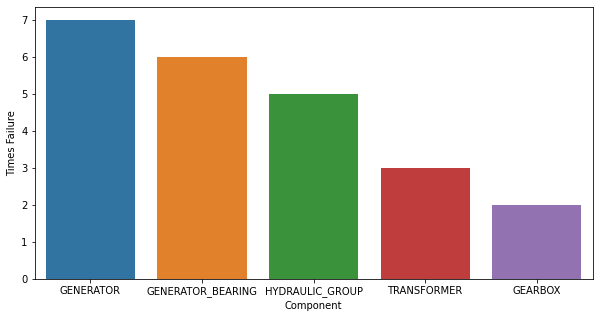

In [9]:
#Number of failures by each component
fig = plt.figure(figsize=(10,5))
nu = failures_df['Component'].value_counts().reset_index()
nu.columns = ['Component','Times Failure']
ax = sns.barplot(x='Component', y='Times Failure', data=nu)

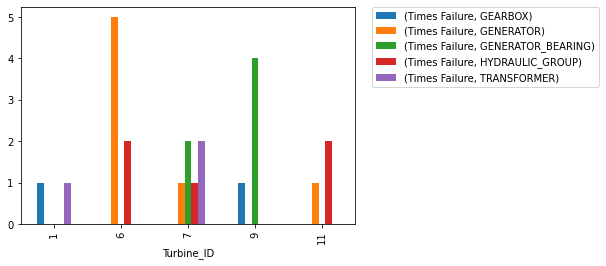

In [10]:
#Failures of components by Turbine
failures_df_by_turbine = failures_df.groupby(['Turbine_ID'])['Component'].value_counts()
failures_df_by_turbine = failures_df_by_turbine.to_frame()
failures_df_by_turbine.columns = ['Times Failure']
temp = failures_df_by_turbine.unstack()
temp.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

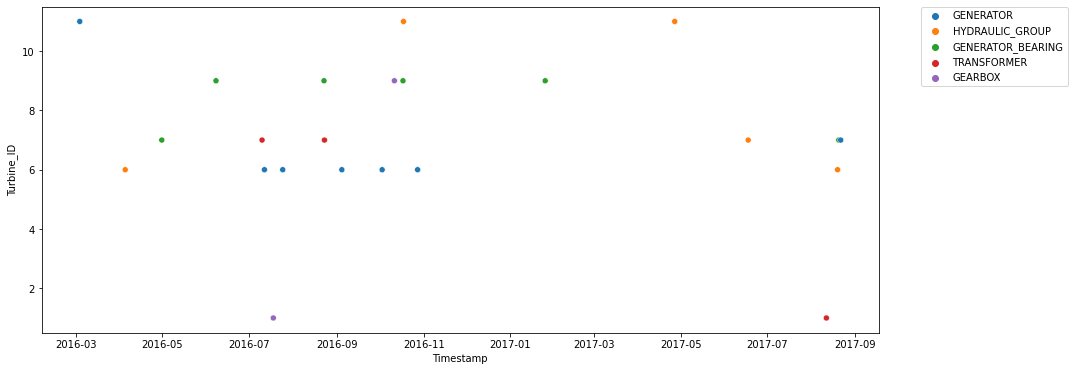

In [11]:
#Failures by component and Turbine across time
turbine_id_list = failures_df['Turbine_ID'].tolist()
component_id_list = failures_df['Component'].tolist()

fig = plt.figure(figsize=(15,6))
sns.scatterplot(x=failures_df.index, y=turbine_id_list, hue=component_id_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Turbine_ID')
plt.xlabel('Timestamp')
plt.show()

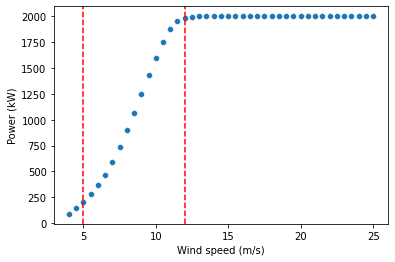

In [12]:
# Three Different phases of the turbines
sns.scatterplot(x=power_df['Wind speed (m/s)'], y=power_df['Power (kW)'])
plt.axvline(x=5, color='red', linestyle= '--')
plt.axvline(x=12, color='red', linestyle= '--')

By Research:

• Region 1: Includes the time when the turbine is starting up;

• Region 2: Operational region in which it is desirable to seize as much wind power as possible;

• Region 3: Wind speeds are relatively high (rated wind speed) and force the turbine to limit the fraction of wind power captured, for electrical and mechanical safety.

In [13]:
#Funtion to analyse by turbine
def turbine(turbine_id, df):
    new_df = df[df['Turbine_ID'] == turbine_id].sort_index(ascending=True)
    return new_df

In [14]:
# Function to find str in columns of df
def component(component, col):
    pair_comp_col=[]
    for i in col:
        if component in i:
            pair_comp_col.append(i)
    return pair_comp_col

In [15]:
# Function to analyse by component
def component_df(component, df):
    df_component = df[df['Component'] == component].sort_index(ascending=True)
    return df_component

In [16]:
#signals of each turbines
t1_df = turbine(1, signals_df)
t6_df = turbine(6, signals_df)
t7_df = turbine(7, signals_df)
t9_df = turbine(9, signals_df)
t11_df = turbine(11, signals_df)

In [17]:
#Failures of each turbines
t1_failures = turbine(1, failures_df)
t6_failures = turbine(6, failures_df)
t7_failures = turbine(7, failures_df)
t9_failures = turbine(9, failures_df)
t11_failures = turbine(11, failures_df)

In [18]:
#Failures of each component
df_generator_failures = component_df('GENERATOR', failures_df)
df_hydraulic_failures = component_df('HYDRAULIC_GROUP', failures_df)
df_bearing_failures = component_df('GENERATOR_BEARING', failures_df)
df_gearbox_failures = component_df('GEARBOX', failures_df)
df_transformer_failures = component_df('TRANSFORMER', failures_df)

In [19]:
pair_gen = component('Gen', signals_df.columns)

In [20]:
pair_gear = component('Gear', signals_df.columns)
pair_gear

['Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg']

In [21]:
pair_trafo = component('Trafo', signals_df.columns)
pair_trafo

['HVTrafo_Phase1_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg']

In [22]:
pair_hyd = component('Hyd', signals_df.columns)
pair_hyd

['Hyd_Oil_Temp_Avg']

# Analysing by Component

In [23]:
# I THINK METEREOLOGICAL DF IS REDUDANT. WIND SPEED IS VERY IMPORTANT BUT IS ALSO ALREADY IN SIGNALS DF. AMB TEMP ALSO
# Let's only focus on signals_df_2016
# Create datasets for each component and label by chosing the correct input variables


# Since we don't know if the other variables are related to the failures, we will also take them in consideration
# Didn't count with "production" - output and most of "grid"
pair_rot = component('Rtr', signals_df.columns)
pair_amb = component('Amb', signals_df.columns)
pair_blds = component('Blds', signals_df.columns)
pair_cont = component('Cont', signals_df.columns)
pair_nac = component('Nac', signals_df.columns)
pair_spin = component('Spin', signals_df.columns)
pair_bus = component('Busbar', signals_df.columns)

In [24]:
temp = signals_df_2016[['Turbine_ID']]

In [25]:
df_signals_generator = signals_df_2016[pair_gen + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
df_signals_gen_bear = signals_df_2016[pair_gen + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
df_signals_transformer = signals_df_2016[pair_trafo + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
df_signals_hydraulic = signals_df_2016[pair_hyd + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
df_signals_gearbox = signals_df_2016[pair_gear + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]

In [26]:
df_signals_generator['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_gen_bear['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_transformer['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_hydraulic['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_gearbox['Turbine_ID'] = temp['Turbine_ID'].to_numpy()

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [27]:
# Classification label
failures_generator = failures_df[failures_df['Component'] == 'GENERATOR']
failures_generator.replace('GENERATOR', 1, inplace=True)
failures_gen_bear = failures_df[failures_df['Component'] == 'GENERATOR_BEARING']
failures_gen_bear.replace('GENERATOR_BEARING', 1, inplace=True)
failures_hyd = failures_df[failures_df['Component'] == 'HYDRAULIC_GROUP']
failures_hyd.replace('HYDRAULIC_GROUP', 1, inplace=True)
failures_gearbox = failures_df[failures_df['Component'] == 'GEARBOX']
failures_gearbox.replace('GEARBOX', 1, inplace=True)
failures_transf = failures_df[failures_df['Component'] == 'TRANSFORMER']
failures_transf.replace('TRANSFORMER', 1, inplace=True)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [28]:
failures_generator_2016 = failures_generator.loc[failures_generator.index < '2017']
failures_gen_bear_2016 = failures_gen_bear.loc[failures_gen_bear.index < '2017']
failures_hyd_2016 = failures_hyd.loc[failures_hyd.index < '2017']
failures_gearbox_2016 = failures_gearbox.loc[failures_gearbox.index < '2017']
failures_transf_2016 = failures_transf.loc[failures_transf.index < '2017']

In [29]:
failures_generator_2016

,Turbine_ID,Component,Remarks
Timestamp,,,
2016-03-03 19:00:00+00:00,11,1,Electric circuit error in generator
2016-07-11 19:48:00+00:00,6,1,Generator replaced
2016-07-24 17:01:00+00:00,6,1,Generator temperature sensor failure
2016-09-04 08:08:00+00:00,6,1,High temperature generator error
2016-10-02 17:08:00+00:00,6,1,Refrigeration system and temperature sensors i...
2016-10-27 16:26:00+00:00,6,1,Generator replaced


In [30]:
#Reset Index to merge df
df_signals_generator.reset_index(inplace=True)
df_signals_gen_bear.reset_index(inplace=True)
df_signals_transformer.reset_index(inplace=True)
df_signals_hydraulic.reset_index(inplace=True)
df_signals_gearbox.reset_index(inplace=True)
failures_generator_2016.reset_index(inplace=True)
failures_gen_bear_2016.reset_index(inplace=True)
failures_hyd_2016.reset_index(inplace=True)
failures_gearbox_2016.reset_index(inplace=True)
failures_transf_2016.reset_index(inplace=True)

In [31]:
#df_signals_generator_final = pd.merge_asof(df_signals_generator, failures_generator_2016, 
 #                                          left_by='Timestamp', right_by='Timestamp', on = 'Turbine_ID', 
  #                                         direction='nearest')
#df_signals_gen_bear_final = pd.merge_asof(df_signals_gen_bear, failures_gen_bear_2016, 
#                                           left_index=True, right_index=True,  left_by='Turbine_ID', right_by='Turbine_ID',
#                                          tolerance=pd.Timedelta("5m"))
#df_signals_hyd_final = pd.merge_asof(df_signals_hydraulic, failures_hyd_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))
#df_signals_gearbox_final = pd.merge_asof(df_signals_gearbox, failures_gearbox_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))
#df_signals_transf_final = pd.merge_asof(df_signals_transformer, failures_transf_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))

##### Não estou a conseguir fazer o merge desta forma

In [32]:
#Reset Index to merge df
df_signals_generator.reset_index(inplace=True)
df_signals_gen_bear.reset_index(inplace=True)
df_signals_transformer.reset_index(inplace=True)
df_signals_hydraulic.reset_index(inplace=True)
df_signals_gearbox.reset_index(inplace=True)
failures_generator_2016.reset_index(inplace=True)
failures_gen_bear_2016.reset_index(inplace=True)
failures_hyd_2016.reset_index(inplace=True)
failures_gearbox_2016.reset_index(inplace=True)
failures_transf_2016.reset_index(inplace=True)

In [33]:
df_signals_generator_final = df_signals_generator.merge(failures_generator_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_gen_bear_final = df_signals_gen_bear.merge(failures_gen_bear_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_hyd_final = df_signals_hydraulic.merge(failures_hyd_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_gearbox_final = df_signals_gearbox.merge(failures_gearbox_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_transf_final = df_signals_transformer.merge(failures_transf_2016, on=['Timestamp', 'Turbine_ID'], how='outer')

In [34]:
#Drop Remarks, index_x, index_y Columns
df_signals_generator_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_gen_bear_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_hyd_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_gearbox_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_transf_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)

In [35]:
#Fill na on component column
df_signals_generator_final['Component'].fillna(0, inplace=True)
df_signals_gen_bear_final['Component'].fillna(0, inplace=True)
df_signals_hyd_final['Component'].fillna(0, inplace=True)
df_signals_gearbox_final['Component'].fillna(0, inplace=True)
df_signals_transf_final['Component'].fillna(0, inplace=True)

In [36]:
# Set Timestamp as Index
df_signals_generator_final.set_index('Timestamp', inplace=True)
df_signals_gen_bear_final.set_index('Timestamp', inplace=True)
df_signals_hyd_final.set_index('Timestamp', inplace=True)
df_signals_gearbox_final.set_index('Timestamp', inplace=True)
df_signals_transf_final.set_index('Timestamp', inplace=True)

In [37]:
# Sort Index
df_signals_generator_final.sort_index(inplace=True)
df_signals_gen_bear_final.sort_index(inplace=True)                                      
df_signals_hyd_final.sort_index(inplace=True)
df_signals_gearbox_final.sort_index(inplace=True)
df_signals_transf_final.sort_index(inplace=True)

In [38]:
# Fill na by interpolate
df_signals_generator_final = df_signals_generator_final.interpolate()
df_signals_gen_bear_final = df_signals_gen_bear_final.interpolate()
df_signals_hyd_final = df_signals_hyd_final.interpolate()
df_signals_gearbox_final = df_signals_gearbox_final.interpolate()
df_signals_transf_final = df_signals_transf_final.interpolate()

In [39]:
#Checking null values in DF's
print(df_signals_generator_final.isnull().values.any())
print(df_signals_gearbox_final.isnull().values.any())
print(df_signals_gen_bear_final.isnull().values.any())
print(df_signals_hyd_final.isnull().values.any())
print(df_signals_transf_final.isnull().values.any())

False
False
False
False
False


In [40]:
# DROP ROWS OF TURBINES WHERE IS NO FAILURES ASSOCIATED

# Base Model for Generator Failures 2016

In [41]:
X = df_signals_generator_final.drop(columns='Component')
y = df_signals_generator_final['Component']

In [42]:
y

Timestamp
2016-01-01 00:00:00+00:00    0.0
2016-01-01 00:00:00+00:00    0.0
2016-01-01 00:00:00+00:00    0.0
2016-01-01 00:00:00+00:00    0.0
2016-01-01 00:00:00+00:00    0.0
                            ... 
2016-12-31 23:50:00+00:00    0.0
2016-12-31 23:50:00+00:00    0.0
2016-12-31 23:50:00+00:00    0.0
2016-12-31 23:50:00+00:00    0.0
2016-12-31 23:50:00+00:00    0.0
Name: Component, Length: 260284, dtype: float64

In [43]:
### Split Train and Test
#split = int(len(X)*0.8)
#X_train, X_test = X[:split], X[split:] 
#y_train, y_test = y[:split], y[split:]

In [44]:
#Standard Scaler
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
#rnd_clf.fit(X_train, y_train)

In [46]:
#y_pred_test = rnd_clf.predict(X_test)

In [47]:
#accuracy_score(y_test, y_pred_test)

# Label RUL

In [48]:
# Creating DF's for Regression Problem Approach
df_signals_gearbox_final.shape, df_signals_generator_final.shape, df_signals_gen_bear_final.shape, df_signals_hyd_final.shape, df_signals_transf_final.shape

((260279, 32), (260284, 44), (260281, 44), (260280, 31), (260280, 33))

In [49]:
df_signals_generator_final['Turbine_ID'].value_counts()

11    52447
7     52445
1     52439
9     52373
6     50580
Name: Turbine_ID, dtype: int64

# DF RUL Failures Generator

In [50]:
df_signals_generator_final = df_signals_generator_final.groupby(by=['Timestamp','Turbine_ID']).mean()

In [51]:
df_signals_generator_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)

In [52]:
df_signals_generator_final.reset_index(inplace=True)

In [53]:
#DF Signals Generator failures on turbine 6 and 11 in 2016
df_signals_generator_t6 = df_signals_generator_final[df_signals_generator_final['Turbine_ID'] == 6]
df_signals_generator_t11 = df_signals_generator_final[df_signals_generator_final['Turbine_ID'] == 11]

In [54]:
df_signals_generator_t6.loc[df_signals_generator_t6['Component'] == 1,'Timestamp']
df_signals_generator_t6 = df_signals_generator_t6.truncate(after=93898)

In [55]:
df_signals_generator_t11.loc[df_signals_generator_t11['Component'] == 1,'Timestamp']
df_signals_generator_t11 = df_signals_generator_t11.truncate(after=216852)

In [56]:
df_signals_generator_t6

,Timestamp,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Cont_VCP_ChokcoilTemp_Avg,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Spin_Temp_Avg,Grd_Busbar_Temp_Avg,Component
52433,2016-01-01 00:00:00+00:00,6,1270.0,1232.80,1248.5,6.8,42.0,51.0,52.0,53.0,...,38.0,28.0,38.0,96.0,38.0,29.0,204.60,20.0,37.0,0.0
52434,2016-01-01 00:10:00+00:00,6,1429.7,203.90,1154.1,271.7,42.0,51.0,52.0,52.0,...,38.0,28.0,38.0,96.0,37.0,29.0,210.50,20.0,37.0,0.0
52435,2016-01-01 00:20:00+00:00,6,1360.5,250.30,1041.4,382.7,42.0,50.0,51.0,51.0,...,38.0,27.0,38.0,93.0,39.0,29.0,199.00,20.0,37.0,0.0
52436,2016-01-01 00:30:00+00:00,6,1399.2,1228.80,1252.5,16.5,42.0,49.0,50.0,50.0,...,38.0,27.0,38.0,92.0,39.0,29.0,205.60,20.0,37.0,0.0
52437,2016-01-01 00:40:00+00:00,6,1302.7,1225.10,1257.6,13.4,41.0,50.0,50.0,51.0,...,38.0,27.0,38.0,94.0,38.0,29.0,207.40,20.0,37.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93894,2016-10-27 15:50:00+00:00,6,1798.6,1606.60,1679.9,28.2,88.0,130.0,133.0,117.0,...,54.0,33.0,51.0,136.0,42.0,40.0,100.80,27.0,56.0,0.0
93895,2016-10-27 16:00:00+00:00,6,1758.4,1614.50,1680.0,25.1,88.0,130.0,133.0,117.0,...,54.0,33.0,51.0,136.0,42.0,40.0,91.70,27.0,56.0,0.0
93896,2016-10-27 16:10:00+00:00,6,1795.0,1609.30,1681.6,25.6,88.0,130.0,133.0,117.0,...,54.0,33.0,51.0,136.0,42.0,39.0,95.20,27.0,56.0,0.0
93897,2016-10-27 16:20:00+00:00,6,1796.3,1577.80,1677.8,31.0,88.0,130.0,133.0,117.0,...,54.0,33.0,51.0,136.0,42.0,39.0,93.10,27.0,56.0,0.0


In [57]:
index_list = df_signals_generator_t6.loc[df_signals_generator_t6['Component'] == 1]

In [58]:
index_list['date'] = index_list['Timestamp']

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
index_list = index_list[['Timestamp','date']]

In [60]:
df = df_signals_generator_t6.merge(index_list, on=['Timestamp'], how='left')

In [61]:
df_generator_t6 = df.fillna(method='bfill')

In [62]:
df_generator_t6['TTF'] = df_generator_t6['date'] - df_generator_t6['Timestamp'] 

In [63]:
df_generator_t6 = df_generator_t6.drop(columns='date')

In [64]:
index_list_t11 = df_signals_generator_t11.loc[df_signals_generator_t11['Component'] == 1]

In [65]:
index_list_t11['date'] = index_list_t11['Timestamp']

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
index_list_t11 = index_list_t11[['Timestamp','date']]

In [67]:
df = df_signals_generator_t11.merge(index_list_t11, on=['Timestamp'], how='left')

In [68]:
df_generator_t11 = df.fillna(method='bfill')

In [69]:
df_generator_t11['TTF'] = df_generator_t11['date'] - df_generator_t11['Timestamp'] 

In [70]:
df_generator_t11 = df_generator_t11.drop(columns='date')

In [71]:
df_generator_t11.shape, df_generator_t6.shape

((9040, 46), (41466, 46))

In [72]:
generator_final = pd.concat([df_generator_t6, df_generator_t11])

In [73]:
generator_final

,Timestamp,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Cont_VCP_ChokcoilTemp_Avg,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Spin_Temp_Avg,Grd_Busbar_Temp_Avg,Component,TTF
0,2016-01-01 00:00:00+00:00,6,1270.0,1232.80,1248.50,6.80,42.0,51.0,52.0,53.0,...,28.0,38.0,96.0,38.0,29.0,204.60,20.0,37.0,0.0,192 days 19:48:00
1,2016-01-01 00:10:00+00:00,6,1429.7,203.90,1154.10,271.70,42.0,51.0,52.0,52.0,...,28.0,38.0,96.0,37.0,29.0,210.50,20.0,37.0,0.0,192 days 19:38:00
2,2016-01-01 00:20:00+00:00,6,1360.5,250.30,1041.40,382.70,42.0,50.0,51.0,51.0,...,27.0,38.0,93.0,39.0,29.0,199.00,20.0,37.0,0.0,192 days 19:28:00
3,2016-01-01 00:30:00+00:00,6,1399.2,1228.80,1252.50,16.50,42.0,49.0,50.0,50.0,...,27.0,38.0,92.0,39.0,29.0,205.60,20.0,37.0,0.0,192 days 19:18:00
4,2016-01-01 00:40:00+00:00,6,1302.7,1225.10,1257.60,13.40,41.0,50.0,50.0,51.0,...,27.0,38.0,94.0,38.0,29.0,207.40,20.0,37.0,0.0,192 days 19:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9035,2016-03-03 18:20:00+00:00,11,0.0,0.00,0.00,0.00,26.0,35.0,35.0,34.0,...,25.0,31.0,27.0,27.0,24.0,247.20,19.0,26.0,0.0,0 days 00:40:00
9036,2016-03-03 18:30:00+00:00,11,0.0,0.00,0.00,0.00,26.0,35.0,35.0,34.0,...,26.0,32.0,27.0,27.0,24.0,247.20,19.0,26.0,0.0,0 days 00:30:00
9037,2016-03-03 18:40:00+00:00,11,262.3,0.00,105.40,106.70,26.0,35.0,34.0,34.0,...,26.0,31.0,27.0,27.0,23.0,247.30,19.0,25.0,0.0,0 days 00:20:00
9038,2016-03-03 18:50:00+00:00,11,22.2,0.00,7.10,5.80,26.0,35.0,34.0,34.0,...,25.0,31.0,27.0,27.0,24.0,262.30,19.0,25.0,0.0,0 days 00:10:00


# DF RUL Failures Gen Bear

In [74]:
df_signals_gen_bear_final = df_signals_gen_bear_final.groupby(by=['Timestamp','Turbine_ID']).mean()

In [75]:
df_signals_gen_bear_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)

In [76]:
df_signals_gen_bear_final.reset_index(inplace=True)

In [77]:
#DF Signals Generator failures on turbine 7 and 9 in 2016
df_signals_gen_bear_t7 = df_signals_gen_bear_final[df_signals_gen_bear_final['Turbine_ID'] == 7]
df_signals_gen_bear_t9 = df_signals_gen_bear_final[df_signals_gen_bear_final['Turbine_ID'] == 9]

In [78]:
df_signals_gen_bear_t7.loc[df_signals_gen_bear_t7['Component'] == 1,'Timestamp']
df_signals_gen_bear_t7 = df_signals_gen_bear_t7.truncate(after=120348)

In [79]:
df_signals_gen_bear_t9.loc[df_signals_gen_bear_t9['Component'] == 1,'Timestamp']
df_signals_gen_bear_t9 = df_signals_gen_bear_t9.truncate(after=196933)

In [80]:
index_list = df_signals_gen_bear_t7.loc[df_signals_gen_bear_t7['Component'] == 1]
index_list['date'] = index_list['Timestamp']
index_list = index_list[['Timestamp','date']]
df = df_signals_gen_bear_t7.merge(index_list, on=['Timestamp'], how='left')
df_gen_bear_t7 = df.fillna(method='bfill')
df_gen_bear_t7['TTF'] = df_gen_bear_t7['date'] - df_gen_bear_t7['Timestamp'] 
df_gen_bear_t7 = df_gen_bear_t7.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
index_list_t9 = df_signals_gen_bear_t9.loc[df_signals_gen_bear_t9['Component'] == 1]
index_list_t9['date'] = index_list_t9['Timestamp']
index_list_t9 = index_list_t9[['Timestamp','date']]
df = df_signals_gen_bear_t9.merge(index_list_t9, on=['Timestamp'], how='left')
df_gen_bear_t9 = df.fillna(method='bfill')
df_gen_bear_t9['TTF'] = df_gen_bear_t9['date'] - df_gen_bear_t9['Timestamp'] 
df_gen_bear_t9 = df_gen_bear_t9.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
gen_bear_final = pd.concat([df_gen_bear_t7, df_gen_bear_t9])

# DF RUL Failures Hydraulic

In [83]:
df_signals_hyd_final = df_signals_hyd_final.groupby(by=['Timestamp','Turbine_ID']).mean()
df_signals_hyd_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)
df_signals_hyd_final.reset_index(inplace=True)
#DF Signals Generator failures on turbine 6 and 11 in 2016
df_signals_hyd_t6 = df_signals_hyd_final[df_signals_hyd_final['Turbine_ID'] == 6]
df_signals_hyd_t11 = df_signals_hyd_final[df_signals_hyd_final['Turbine_ID'] == 11]

In [84]:
df_signals_hyd_t6.loc[df_signals_hyd_t6['Component'] == 1,'Timestamp']
df_signals_hyd_t6 = df_signals_hyd_t6.truncate(after=66073)

In [85]:
df_signals_hyd_t11.loc[df_signals_hyd_t11['Component'] == 1,'Timestamp']
df_signals_hyd_t11 = df_signals_hyd_t11.truncate(after=249412)

In [86]:
index_list = df_signals_hyd_t11.loc[df_signals_hyd_t11['Component'] == 1]
index_list['date'] = index_list['Timestamp']
index_list = index_list[['Timestamp','date']]
df = df_signals_hyd_t11.merge(index_list, on=['Timestamp'], how='left')
df_hyd_t11 = df.fillna(method='bfill')
df_hyd_t11['TTF'] = df_hyd_t11['date'] - df_hyd_t11['Timestamp'] 
df_hyd_t11 = df_hyd_t11.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
index_list_t6 = df_signals_hyd_t6.loc[df_signals_hyd_t6['Component'] == 1]
index_list_t6['date'] = index_list_t6['Timestamp']
index_list_t6 = index_list_t6[['Timestamp','date']]
df = df_signals_hyd_t6.merge(index_list_t6, on=['Timestamp'], how='left')
df_hyd_t6 = df.fillna(method='bfill')
df_hyd_t6['TTF'] = df_hyd_t6['date'] - df_hyd_t6['Timestamp'] 
df_hyd_t6 = df_hyd_t6.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
hyd_final = pd.concat([df_hyd_t6, df_hyd_t11])

In [89]:
hyd_final

,Timestamp,Turbine_ID,Hyd_Oil_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Rtr_RPM_Std,...,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Cont_VCP_ChokcoilTemp_Avg,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Spin_Temp_Avg,Grd_Busbar_Temp_Avg,Component,TTF
0,2016-01-01 00:00:00+00:00,6,30.0,11.2,10.9,11.10,40.0,40.0,38.0,0.1,...,28.0,38.0,96.0,38.0,29.0,204.6,20.0,37.0,0.0,94 days 18:53:00
1,2016-01-01 00:10:00+00:00,6,30.0,12.6,2.0,10.20,38.0,38.0,36.0,2.4,...,28.0,38.0,96.0,37.0,29.0,210.5,20.0,37.0,0.0,94 days 18:43:00
2,2016-01-01 00:20:00+00:00,6,31.0,12.0,2.3,9.20,39.0,39.0,37.0,3.4,...,27.0,38.0,93.0,39.0,29.0,199.0,20.0,37.0,0.0,94 days 18:33:00
3,2016-01-01 00:30:00+00:00,6,31.0,12.2,10.9,11.10,40.0,40.0,38.0,0.1,...,27.0,38.0,92.0,39.0,29.0,205.6,20.0,37.0,0.0,94 days 18:23:00
4,2016-01-01 00:40:00+00:00,6,31.0,11.5,10.9,11.10,40.0,40.0,38.0,0.1,...,27.0,38.0,94.0,38.0,29.0,207.4,20.0,37.0,0.0,94 days 18:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41599,2016-10-17 17:10:00+00:00,11,37.0,2.3,0.0,0.60,34.0,35.0,35.0,0.9,...,35.0,39.0,33.0,35.0,33.0,272.5,32.0,34.0,0.0,0 days 00:34:00
41600,2016-10-17 17:20:00+00:00,11,37.0,12.2,0.0,3.60,34.0,36.0,36.0,3.4,...,35.0,39.0,34.0,35.0,34.0,273.9,32.0,35.0,0.0,0 days 00:24:00
41601,2016-10-17 17:30:00+00:00,11,37.0,0.0,0.0,0.00,36.0,37.0,37.0,0.0,...,36.0,41.0,35.0,36.0,34.0,280.2,31.0,35.0,0.0,0 days 00:14:00
41602,2016-10-17 17:40:00+00:00,11,36.0,0.0,0.0,0.00,36.0,37.0,37.0,0.0,...,36.0,41.0,35.0,37.0,34.0,280.2,31.0,35.0,0.0,0 days 00:04:00


# DF RUL Failures GearBox

In [90]:
df_signals_gearbox_final = df_signals_gearbox_final.groupby(by=['Timestamp','Turbine_ID']).mean()
df_signals_gearbox_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)
df_signals_gearbox_final.reset_index(inplace=True)
#DF Signals Generator failures on turbine 1 and 9 in 2016
df_signals_gearbox_t1 = df_signals_gearbox_final[df_signals_gearbox_final['Turbine_ID'] == 1]
df_signals_gearbox_t9 = df_signals_gearbox_final[df_signals_gearbox_final['Turbine_ID'] == 9]

In [91]:
df_signals_gearbox_t1.loc[df_signals_gearbox_t1['Component'] == 1,'Timestamp']
df_signals_gearbox_t1 = df_signals_gearbox_t1.truncate(after=28632)

In [92]:
df_signals_gearbox_t9.loc[df_signals_gearbox_t9['Component'] == 1,'Timestamp']
df_signals_gearbox_t9 = df_signals_gearbox_t9.truncate(after=196073)

In [93]:
index_list = df_signals_gearbox_t1.loc[df_signals_gearbox_t1['Component'] == 1]
index_list['date'] = index_list['Timestamp']
index_list = index_list[['Timestamp','date']]
df = df_signals_gearbox_t1.merge(index_list, on=['Timestamp'], how='left')
df_gearbox_t1 = df.fillna(method='bfill')
df_gearbox_t1['TTF'] = df_gearbox_t1['date'] - df_gearbox_t1['Timestamp'] 
df_gearbox_t1 = df_gearbox_t1.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
index_list_t9 = df_signals_gearbox_t9.loc[df_signals_gearbox_t9['Component'] == 1]
index_list_t9['date'] = index_list_t9['Timestamp']
index_list_t9 = index_list_t9[['Timestamp','date']]
df = df_signals_gearbox_t9.merge(index_list_t9, on=['Timestamp'], how='left')
df_gearbox_t9 = df.fillna(method='bfill')
df_gearbox_t9['TTF'] = df_gearbox_t9['date'] - df_gearbox_t9['Timestamp'] 
df_gearbox_t9 = df_gearbox_t9.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [95]:
gearbox_final = pd.concat([df_gearbox_t1, df_gearbox_t9])

In [96]:
gearbox_final

,Timestamp,Turbine_ID,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,...,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Cont_VCP_ChokcoilTemp_Avg,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Spin_Temp_Avg,Grd_Busbar_Temp_Avg,Component,TTF
0,2016-01-01 00:00:00+00:00,1,44.0,48.0,11.30,10.9,11.10,39.0,39.0,38.0,...,28.0,43.0,91.0,39.0,28.0,218.50,20.0,38.0,0.0,199 days 02:10:00
1,2016-01-01 00:10:00+00:00,1,44.0,48.0,11.20,0.0,8.80,37.0,36.0,37.0,...,28.0,42.0,91.0,37.0,28.0,218.50,20.0,38.0,0.0,199 days 02:00:00
2,2016-01-01 00:20:00+00:00,1,43.0,46.0,12.30,1.9,6.80,38.0,37.0,37.0,...,28.0,42.0,87.0,38.0,29.0,213.30,20.0,38.0,0.0,199 days 01:50:00
3,2016-01-01 00:30:00+00:00,1,44.0,48.0,11.50,10.7,11.10,38.0,38.0,38.0,...,28.0,42.0,87.0,38.0,28.0,222.40,20.0,38.0,0.0,199 days 01:40:00
4,2016-01-01 00:40:00+00:00,1,44.0,48.0,11.70,10.8,11.10,39.0,38.0,38.0,...,28.0,42.0,88.0,39.0,28.0,222.40,20.0,38.0,0.0,199 days 01:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40628,2016-10-11 07:30:00+00:00,9,36.0,36.0,2.20,1.8,2.00,30.0,32.0,31.0,...,28.0,33.0,37.0,30.0,27.0,196.10,21.0,27.0,0.0,0 days 00:36:00
40629,2016-10-11 07:40:00+00:00,9,35.0,36.0,2.10,2.0,2.00,30.0,31.0,31.0,...,28.0,33.0,36.0,30.0,27.0,194.70,21.0,27.0,0.0,0 days 00:26:00
40630,2016-10-11 07:50:00+00:00,9,35.0,36.0,2.10,1.9,2.00,30.0,31.0,31.0,...,28.0,33.0,35.0,30.0,27.0,194.70,21.0,27.0,0.0,0 days 00:16:00
40631,2016-10-11 08:00:00+00:00,9,35.0,36.0,2.20,1.6,1.90,30.0,31.0,31.0,...,28.0,33.0,35.0,29.0,27.0,194.70,20.0,27.0,0.0,0 days 00:06:00


# DF RUL Failures Transformer

In [97]:
df_signals_transf_final = df_signals_transf_final.groupby(by=['Timestamp','Turbine_ID']).mean()
df_signals_transf_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)
df_signals_transf_final.reset_index(inplace=True)
#DF Signals Generator failures on turbine 7 in 2016
df_signals_transf_t7 = df_signals_transf_final[df_signals_transf_final['Turbine_ID'] == 7]

In [98]:
df_signals_transf_t7.loc[df_signals_transf_t7['Component'] == 1,'Timestamp']
df_signals_transf_t7 = df_signals_transf_t7.truncate(after=136821)

In [99]:
index_list = df_signals_transf_t7.loc[df_signals_transf_t7['Component'] == 1]
index_list['date'] = index_list['Timestamp']
index_list = index_list[['Timestamp','date']]
df = df_signals_transf_t7.merge(index_list, on=['Timestamp'], how='left')
df_transf_t7 = df.fillna(method='bfill')
df_transf_t7['TTF'] = df_transf_t7['date'] - df_transf_t7['Timestamp'] 
df_transf_t7 = df_transf_t7.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
transf_final = df_transf_t7.copy()

In [101]:
transf_final.shape, gearbox_final.shape, generator_final.shape, gen_bear_final.shape, hyd_final.shape

((33820, 35), (69266, 34), (50506, 46), (58840, 46), (55245, 33))

In [102]:
transf_final['TTF'] = transf_final['TTF'].dt.days
gearbox_final['TTF'] = gearbox_final['TTF'].dt.days
generator_final['TTF'] = generator_final['TTF'].dt.days
gen_bear_final['TTF'] = gen_bear_final['TTF'].dt.days
hyd_final['TTF'] = hyd_final['TTF'].dt.days

In [103]:
def Failure_Time_Horizon(days, period):
    if days <= period:
        Flag=1
    else:
        Flag=0
    return Flag

In [106]:
transf_final['60_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
gearbox_final['60_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
generator_final['60_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
gen_bear_final['60_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
hyd_final['60_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)

In [107]:
transf_final['40_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
gearbox_final['40_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
generator_final['40_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
gen_bear_final['40_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
hyd_final['40_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)

In [108]:
transf_final['30_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
gearbox_final['30_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
generator_final['30_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
gen_bear_final['30_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
hyd_final['30_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)

In [109]:
transf_final['20_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
gearbox_final['20_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
generator_final['20_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
gen_bear_final['20_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
hyd_final['20_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)

In [110]:
transf_final['10_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
gearbox_final['10_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
generator_final['10_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
gen_bear_final['10_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
hyd_final['10_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)

In [111]:
transf_final['2_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)
gearbox_final['2_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)
generator_final['2_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)
gen_bear_final['2_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)
hyd_final['2_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)

# TRAINING